# Setup

This example script requires a number of extra packages to be installed:

<list>
    <li><a href="https://github.com/SeanNaren/deepspeech.pytorch">deepspeech_pytorch</a></li>
    <li><a href="https://github.com/omry/omegaconf">omegaconf</a>
    <li><a href="https://github.com/PyTorchLightning/pytorch-lightning">pytorch_lightning</a></li>
</list>

The $\mathrm{DeepSpeech}$ class defined below is a slightly modified version of the similarly named class in the <a href="https://github.com/SeanNaren/deepspeech.pytorch/blob/master/deepspeech_pytorch/model.py">models.py</a> module of the $\mathrm{deepspeech\_pytorch}$ package.

To replicate the results in this notebook, the following additional resources are provided:

<list>
    <li>Pretrained DeepSpeech model: $\text{deepspeech2-pretrained.ckpt}$</li>
    <li>Sample 4-second 16KHz audio clips extracted from the <em>test-clean</em> and <em>dev-clean</em> subsets of the LibriSpeech corpus: $\text{segments-librispeech-*}$</li>
</list>

To replicate the results here, extract $\text{Examples/resources.tar}$ and place the contents in a folder named $\text{resources/}$.

In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchaudio
from torch.cuda.amp import autocast
torchaudio.set_audio_backend("sox_io")

from omegaconf import OmegaConf
from deepspeech_pytorch.configs.train_config import SpectConfig, BiDirectionalConfig, AdamConfig, SGDConfig
from deepspeech_pytorch.decoder import GreedyDecoder
from deepspeech_pytorch.utils import load_model
from deepspeech_pytorch.validation import CharErrorRate, WordErrorRate
from deepspeech_pytorch.model import SequenceWise, MaskConv, InferenceBatchSoftmax, Lookahead
from deepspeech_pytorch.enums import RNNType, SpectrogramWindow
import pytorch_lightning as pl

import PyTCI.tci as tci
import PyTCI.audio as fx

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


LABELS = list("_'ABCDEFGHIJKLMNOPQRSTUVWXYZ ")
MODEL_CFG = BiDirectionalConfig(rnn_type=RNNType.lstm, hidden_size=1024, hidden_layers=7)
OPTIM_CFG = AdamConfig(learning_rate=0.00015, learning_anneal=0.99, weight_decay=1e-05, eps=1e-08, betas=[0.9, 0.999])
SPECT_CFG = SpectConfig(sample_rate=16000, window_size=0.02, window_stride=0.01, window=SpectrogramWindow.hamming)
PRECISION = 16


class SpectrogramParser(nn.Module):
    def __init__(self, audio_conf: SpectConfig, normalize: bool = False):
        """
       	Parses audio file into spectrogram with optional normalization
       	:param audio_conf: Dictionary containing the sample rate, window and the window length/stride in seconds
       	:param normalize(default False):  Apply standard mean and deviation normalization to audio tensor
       	"""
        super().__init__()
        self.window_stride = audio_conf.window_stride
        self.window_size = audio_conf.window_size
        self.sample_rate = audio_conf.sample_rate
        self.window = audio_conf.window.value
        self.normalize = normalize
        
        n_fft = int(self.sample_rate * self.window_size)
        win_length = n_fft
        hop_length = int(self.sample_rate * self.window_stride)
        if self.window == 'hamming':
            window = torch.hamming_window
        else:
            raise NotImplementedError()
        
        self.transform = torchaudio.transforms.Spectrogram(
            n_fft, win_length, hop_length, window_fn=window, power=1, normalized=False)

    @torch.no_grad()
    def forward(self, audio):
        if audio.shape[-1] == 1:
            audio = audio.squeeze(dim=-1) # mono
        else:
            audio = audio.mean(dim=-1) # multiple channels, average
        
        # trim final samples if extra samples left out from downsampling doing conversion
        audio = audio[:-round(len(audio) % self.transform.hop_length)-1]
        
        spect = self.transform(audio)
        spect = torch.log1p(spect)
        
        if self.normalize:
            mean = spect.mean()
            std = spect.std()
            spect.add_(-mean)
            spect.div_(std)
        
        # reshape to [time x frequency]
        spect = spect.T.contiguous()
        
        return spect


class BatchRNN(nn.Module):
    def __init__(self, input_size, hidden_size, rnn_type=nn.LSTM, bidirectional=False, batch_norm=True):
        super(BatchRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.batch_norm = SequenceWise(nn.BatchNorm1d(input_size)) if batch_norm else None
        self.rnn = rnn_type(input_size=input_size, hidden_size=hidden_size,
                            bidirectional=bidirectional, bias=True)
        self.num_directions = 2 if bidirectional else 1

    def flatten_parameters(self):
        self.rnn.flatten_parameters()

    def forward(self, x, output_lengths):
        if self.batch_norm is not None:
            x = self.batch_norm(x)
        x = nn.utils.rnn.pack_padded_sequence(x, output_lengths, enforce_sorted=False)
        x, h = self.rnn(x)
        x, _ = nn.utils.rnn.pad_packed_sequence(x)
        if self.bidirectional:
            x = x.view(x.size(0), x.size(1), 2, -1).sum(2).view(x.size(0), x.size(1), -1)  # (TxNxH*2) -> (TxNxH) by sum
        return x


class DeepSpeech(pl.LightningModule):
    def __init__(self, labels=LABELS, model_cfg=MODEL_CFG, precision=PRECISION, optim_cfg=OPTIM_CFG, spect_cfg=SPECT_CFG):
        super().__init__()
        self.save_hyperparameters()
        self.model_cfg = model_cfg
        self.precision = precision
        self.optim_cfg = optim_cfg
        self.spect_cfg = spect_cfg
        self.bidirectional = True if OmegaConf.get_type(model_cfg) is BiDirectionalConfig else False

        self.labels = labels
        num_classes = len(self.labels)

        self.conv = MaskConv(nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(41, 11), stride=(2, 2), padding=(20, 5)),
            nn.BatchNorm2d(32),
            nn.Hardtanh(0, 20, inplace=True),
            nn.Conv2d(32, 32, kernel_size=(21, 11), stride=(2, 1), padding=(10, 5)),
            nn.BatchNorm2d(32),
            nn.Hardtanh(0, 20, inplace=True)
        ))
        # Based on above convolutions and spectrogram size using conv formula (W - F + 2P)/ S+1
        rnn_input_size = int(math.floor((self.spect_cfg.sample_rate * self.spect_cfg.window_size) / 2) + 1)
        rnn_input_size = int(math.floor(rnn_input_size + 2 * 20 - 41) / 2 + 1)
        rnn_input_size = int(math.floor(rnn_input_size + 2 * 10 - 21) / 2 + 1)
        rnn_input_size *= 32

        self.rnns = nn.Sequential(
            BatchRNN(
                input_size=rnn_input_size,
                hidden_size=self.model_cfg.hidden_size,
                rnn_type=self.model_cfg.rnn_type.value,
                bidirectional=self.bidirectional,
                batch_norm=False
            ),
            *(
                BatchRNN(
                    input_size=self.model_cfg.hidden_size,
                    hidden_size=self.model_cfg.hidden_size,
                    rnn_type=self.model_cfg.rnn_type.value,
                    bidirectional=self.bidirectional
                ) for x in range(self.model_cfg.hidden_layers - 3)
            )
        )

        self.lookahead = nn.Sequential(
            # consider adding batch norm?
            Lookahead(self.model_cfg.hidden_size, context=self.model_cfg.lookahead_context),
            nn.Hardtanh(0, 20, inplace=True)
        ) if not self.bidirectional else None

        fully_connected = nn.Sequential(
            nn.BatchNorm1d(self.model_cfg.hidden_size),
            nn.Linear(self.model_cfg.hidden_size, num_classes, bias=False)
        )
        self.fc = nn.Sequential(
            SequenceWise(fully_connected),
        )
        self.inference_softmax = InferenceBatchSoftmax()
        self.criterion = nn.CTCLoss(blank=self.labels.index('_'), reduction='sum', zero_infinity=True)
        self.evaluation_decoder = GreedyDecoder(self.labels)  # Decoder used for validation
        self.wer = WordErrorRate(
            decoder=self.evaluation_decoder,
            target_decoder=self.evaluation_decoder
        )
        self.cer = CharErrorRate(
            decoder=self.evaluation_decoder,
            target_decoder=self.evaluation_decoder
        )

    def forward(self, x, lengths):
        lengths = lengths.cpu().int()
        output_lengths = self.get_seq_lens(lengths)
        x, _ = self.conv(x.transpose(1,2).unsqueeze(1).contiguous(), output_lengths)

        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # Collapse feature dimension
        x = x.transpose(1, 2).transpose(0, 1).contiguous()  # TxNxH

        for rnn in self.rnns:
            x = rnn(x, output_lengths)

        if not self.bidirectional:  # no need for lookahead layer in bidirectional
            x = self.lookahead(x)

        x = self.fc(x)
        x = x.transpose(0, 1)
        # identity in training mode, softmax in eval mode
        x = self.inference_softmax(x)
        return x, output_lengths
    
    def unpack_batch(self, batch):
        inputs = batch.get('inputs', None)
        input_lengths = batch.get('input_lengths', None)
        labels = batch.get('labels', None)
        label_lengths = batch.get('label_lengths', None)
        
        return inputs, labels, input_lengths, label_lengths

    def training_step(self, batch, batch_idx):
        inputs, targets, input_sizes, target_sizes = self.unpack_batch(batch)
        if inputs is None: # skip step
            return None
        
        out, output_sizes = self(inputs, input_sizes)
        out = out.transpose(0, 1)  # TxNxH
        out = out.log_softmax(-1)

        loss = self.criterion(out, targets, output_sizes, target_sizes)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets, input_sizes, target_sizes = self.unpack_batch(batch)
        if inputs is None: # skip step
            return
        
        inputs = inputs.to(self.device)
        with autocast(enabled=self.precision == 16):
            out, output_sizes = self(inputs, input_sizes)
        decoded_output, _ = self.evaluation_decoder.decode(out, output_sizes)
        
        self.wer(preds=out, preds_sizes=output_sizes, targets=targets, target_sizes=target_sizes)
        self.cer(preds=out, preds_sizes=output_sizes, targets=targets, target_sizes=target_sizes)
        self.log('wer', self.wer.compute(), prog_bar=True, on_epoch=True)
        self.log('cer', self.cer.compute(), prog_bar=True, on_epoch=True)
    
    def test_step(self, *args):
        return self.validation_step(*args)

    def configure_optimizers(self):
        if OmegaConf.get_type(self.optim_cfg) is SGDConfig:
            optimizer = torch.optim.SGD(
                params=self.parameters(),
                lr=self.optim_cfg.learning_rate,
                momentum=self.optim_cfg.momentum,
                nesterov=True,
                weight_decay=self.optim_cfg.weight_decay
            )
        elif OmegaConf.get_type(self.optim_cfg) is AdamConfig:
            optimizer = torch.optim.AdamW(
                params=self.parameters(),
                lr=self.optim_cfg.learning_rate,
                betas=self.optim_cfg.betas,
                eps=self.optim_cfg.eps,
                weight_decay=self.optim_cfg.weight_decay
            )
        else:
            raise ValueError("Optimizer has not been specified correctly.")

        scheduler = torch.optim.lr_scheduler.ExponentialLR(
            optimizer=optimizer,
            gamma=self.optim_cfg.learning_anneal
        )
        return [optimizer], [scheduler]

    def get_seq_lens(self, input_length):
        """
        Given a 1D Tensor or Variable containing integer sequence lengths, return a 1D tensor or variable
        containing the size sequences that will be output by the network.
        :param input_length: 1D Tensor
        :return: 1D Tensor scaled by model
        """
        seq_len = input_length
        for m in self.conv.modules():
            if type(m) == nn.modules.conv.Conv2d:
                seq_len = torch.div(
                    seq_len + 2 * m.padding[1] - m.dilation[1] * (m.kernel_size[1] - 1) - 1,
                    m.stride[1], rounding_mode='floor'
                ) + 1
        return seq_len.int()
    
    @torch.no_grad()
    def activation_fx(self, layer, log=True):
        # waveform 2 spectrogram parser
        spect_parser = SpectrogramParser(audio_conf=SPECT_CFG, normalize=True).to(self.device)
        
        def activation(x, /, layer=layer):
            # convert to spectrogram
            x = spect_parser(x)
            lengths = torch.tensor([x.shape[0]], dtype=int)
            output_lengths = self.get_seq_lens(lengths)
            
            # make into 4D tensor of [batch x channel x frequency x time]
            # and move to same device as the model
            x = x.T[np.newaxis, np.newaxis, ...].contiguous().to(device)
            
            for module in self.conv.seq_module:
                x = module(x)
                mask = torch.BoolTensor(x.size()).fill_(0)
                if x.is_cuda:
                    mask = mask.cuda()
                for i, length in enumerate(output_lengths):
                    length = length.item()
                    if (mask[i].size(2) - length) > 0:
                        mask[i].narrow(2, length, mask[i].size(2) - length).fill_(1)
                x = x.masked_fill(mask, 0)
                
                if isinstance(module, torch.nn.Hardtanh):
                    layer -= 1
                    if layer < 0:
                        break
            
            sizes = x.size()
            x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # Collapse feature dimension
            x = x.transpose(1, 2).transpose(0, 1).contiguous()  # TxNxH
            if layer < 0:
                #import pdb; pdb.set_trace()
                return x.squeeze(dim=1).cpu()
            
            for rnn in self.rnns:
                x = rnn(x, output_lengths)
                layer -= 1
                if layer < 0:
                    return x.squeeze(dim=1).cpu()
            
            if not self.bidirectional:  # no need for lookahead layer in bidirectional
                x = self.lookahead(x)
            
            x = self.fc(x)
            
            # identity in training mode, softmax in eval mode
            if log:
                x = torch.nn.functional.log_softmax(x, dim=-1)
            else:
                x = torch.nn.functional.softmax(x, dim=-1)
            layer -= 1
            if layer < 0:
                return x.squeeze(dim=1).cpu()
            
            return None
        
        return activation


# Pretrained DeepSpeech2 model
model = DeepSpeech().to(device).eval()
model.load_state_dict(torch.load('resources/deepspeech2-pretrained.ckpt')['state_dict'])

# Model output sampling rate
out_sr = 50

# Measuring integration windows

This section demonstrates how to measure integration windows for a more complex deep neural network with multiple layers. To do this, we need to define a function that takes in input $\mathrm{x}$ and returns output $\mathrm{y}$, which in this case is the activations at a specific layer $\mathrm{layer}$. The shape of both $\mathrm{x}$ and $\mathrm{y}$ should be of form $[ time \times channels ]$.

We first define a wrapper function to estimate integration windows of all nodes in a layer:

In [2]:
# Wrapper function to estimate integration windows of a layer
def estimate_layer_intwin(layer, stimuli, segment_durs, in_sr, out_sr):
    sequence_pairs = tci.generate_sequence_pair(
        stimuli, in_sr, segment_durs
    )
    
    response_pairs = tci.infer_sequence_pair(
        model.activation_fx(layer), sequence_pairs, segment_durs,
        in_sr=in_sr, out_sr=out_sr, block_size=48.0, context_size=8.0, device=device
    )
    
    SAR_pairs = tci.rearrange_sequence_pair(
        response_pairs, out_sr, segment_durs
    )
    
    cross_context_corrs = tci.cross_context_corrs(
        SAR_pairs, batch_size=100
    )
    
    integration_windows = tci.estimate_integration_window(
        cross_context_corrs, segment_durs, threshold=0.75
    )
    
    return integration_windows

We now analyze the first, fourth and sixth layers of the model:

In [3]:
stimuli, in_sr = tci.load_stimuli('resources/segments-librispeech-1k/')

segment_durs = tci.SEGMENT_DURS

print('> Conv1... ', flush=True, end='')
intwin_conv1_norm = estimate_layer_intwin(0, stimuli, segment_durs, in_sr, out_sr)
print('Done.')

print('> LSTM2... ', flush=True, end='')
intwin_lstm2_norm = estimate_layer_intwin(3, stimuli, segment_durs, in_sr, out_sr)
print('Done.')

print('> LSTM4... ', flush=True, end='')
intwin_lstm4_norm = estimate_layer_intwin(5, stimuli, segment_durs, in_sr, out_sr)
print('Done.')

> Conv1... Done.
> LSTM2... Done.
> LSTM4... Done.


The results show increasing integration windows as we look deeper in the network.

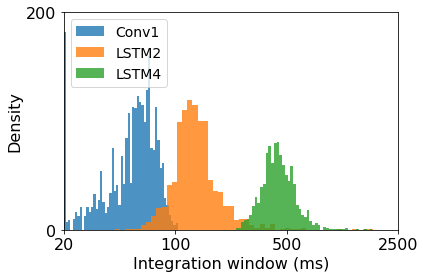

In [4]:
plt.figure(figsize=(6, 4))
plt.hist(np.log10(intwin_conv1_norm), bins=50, alpha=0.8, label='Conv1')
plt.hist(np.log10(intwin_lstm2_norm), bins=50, alpha=0.8, label='LSTM2')
plt.hist(np.log10(intwin_lstm4_norm), bins=50, alpha=0.8, label='LSTM4')
plt.xticks(np.log10([0.02, 0.1, 0.5, 2.5]), [20, 100, 500, 2500], fontsize=16)
plt.yticks([0, 200], fontsize=16)
plt.xlabel('Integration window (ms)', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.legend(loc='upper left', fontsize=14)
plt.xlim(np.log10([0.02, 2.5]))
plt.show()

# Measuring adaptation indices

In this section, we study whether the model adapts its integration window depending on the input speech rate, to match the length of abstract structures in speech, rather than fixed integration windows, i.e., a fixed duration of speech.

To do this, we can either preprocess the stimuli independently or use the `process` parameter of `load_stimuli` and `process_stimuli`. There are a number of basic audio processing functions based on the SoX backend of the torchaudio library in the `PyTCI.audio` module, including audio stretching while preserving the audio pitch, named `tempo_fx`, which we use in this example.

We then compute the adaptation index, as defined in the paper:

\begin{equation*}
\mathrm{adaptation\;index} = \frac{I_{mod}/I_{ref} - 1}{D_{mod}/D_{ref} - 1}
\end{equation*}

where $I_{mod}$ and $I_{ref}$ are integration windows for modified (i.e., slowed-down) and reference (i.e., natural) stimuli, and $D_{mod}/D_{ref}$ is the ratio of the duration of the stimuli between modified and reference conditions. Given the definition, a non-adaptive model with a fixed window would have an adaptation index of ~0, and a fully-adaptive model with flexible integration would have an adaptation index of ~1.

<strong>NOTE</strong>: the scaling factor input to the `temp_fx` and `speed_fx` functions are the scaling factor for the rate, not duration, so to increase stimuli duration by 60%, we have to set the rate scaling to $\frac{1}{1.6}$.

In [7]:
# Estimate integration periods for 60% longer stimuli
time_stretch_factor = 1.6
stimuli, in_sr = tci.load_stimuli(
    'resources/segments-librispeech-1k/',
    process=fx.tempo_fx(scale_factor=1/time_stretch_factor)
)

print('> Conv1 (slowed-down)... ', flush=True, end='')
intwin_conv1_slow = estimate_layer_intwin(0, stimuli, segment_durs, in_sr, out_sr)
print('Done.')

print('> LSTM2 (slowed-down)... ', flush=True, end='')
intwin_lstm2_slow = estimate_layer_intwin(3, stimuli, segment_durs, in_sr, out_sr)
print('Done.')

print('> LSTM4 (slowed-down)... ', flush=True, end='')
intwin_lstm4_slow = estimate_layer_intwin(5, stimuli, segment_durs, in_sr, out_sr)
print('Done.')

> Conv1 (slowed-down)... Done.
> LSTM2 (slowed-down)... Done.
> LSTM4 (slowed-down)... Done.


We calculate the adaptation index as described in the paper, based on the two conditions:

In [8]:
adaptation_conv1 = (intwin_conv1_slow/intwin_conv1_norm - 1) / (time_stretch_factor - 1)
adaptation_lstm2 = (intwin_lstm2_slow/intwin_lstm2_norm - 1) / (time_stretch_factor - 1)
adaptation_lstm4 = (intwin_lstm4_slow/intwin_lstm4_norm - 1) / (time_stretch_factor - 1)

Comparing the integration windows between the two conditions, demonstrates how the network layers transition from short and fixed integration windows (close to black dashed line) to long and flexible integrations (close to red dashed line):

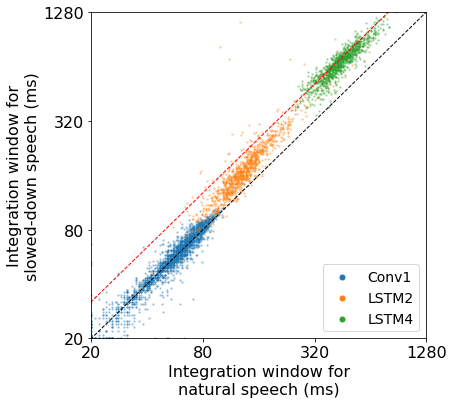

In [9]:
plt.figure(figsize=(6, 6))
plt.plot(np.log10([0.018, 1.28]), np.log10([0.018, 1.28]), 'k--', linewidth=1)
plt.plot(np.log10([0.018, 1.28]), np.log10([0.018, 1.28])+np.log10(1.6), 'r--', linewidth=1)
plt.scatter(
    np.log10(intwin_conv1_norm),
    np.log10(intwin_conv1_slow),
    2, alpha=0.3, label='Conv1'
)
plt.scatter(
    np.log10(intwin_lstm2_norm),
    np.log10(intwin_lstm2_slow),
    2, alpha=0.3, label='LSTM2'
)
plt.scatter(
    np.log10(intwin_lstm4_norm),
    np.log10(intwin_lstm4_slow),
    2, alpha=0.3, label='LSTM4'
)
plt.xticks(np.log10([0.02, 0.08, 0.32, 1.28]), [20, 80, 320, 1280], fontsize=16)
plt.yticks(np.log10([0.02, 0.08, 0.32, 1.28]), [20, 80, 320, 1280], fontsize=16)
plt.xlabel('Integration window for\nnatural speech (ms)', fontsize=16)
plt.ylabel('Integration window for\nslowed-down speech (ms)', fontsize=16)
plt.xlim(np.log10([0.02, 1.28]))
plt.ylim(np.log10([0.02, 1.28]))
legend = plt.legend(loc='lower right', fontsize=14)
for h in legend.legendHandles:
    h.set_sizes([25])
    h.set_alpha(1)
plt.show()

The adaptation indices quantify this transition in a clearer way:

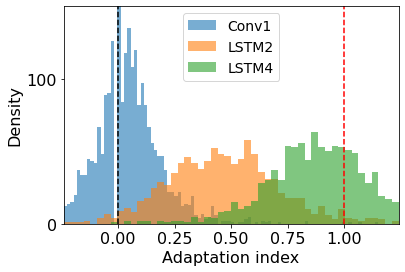

In [10]:
plt.figure(figsize=(6, 4))
plt.hist(adaptation_conv1, bins=100, alpha=0.6, range=(-0.24, 1.24), label='Conv1')
plt.hist(adaptation_lstm2, bins=50, alpha=0.6, range=(-0.24, 1.24), label='LSTM2')
plt.hist(adaptation_lstm4, bins=50, alpha=0.6, range=(-0.24, 1.24), label='LSTM4')
plt.legend(fontsize=14)
plt.xticks([0, 0.25, 0.5, 0.75, 1.0], fontsize=16)
plt.yticks([0, 100], fontsize=16)
plt.plot([0, 0], [0, 150], 'k--')
plt.plot([1, 1], [0, 150], 'r--')
plt.xlabel('Adaptation index', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.xlim([-0.24, 1.24])
plt.ylim([0, 150])
plt.show()